In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
store = pd.read_csv('Data/store.csv')
train_1 = pd.read_csv('Data/train_1.csv')
train_2 = pd.read_csv('Data/train_2.csv')
train = pd.concat([train_1, train_2], axis=0)
train= train.drop(columns=['Unnamed: 0']).reset_index(drop = True)

print('store : ',store.shape)
print('train : ',train.shape)

C:\Users\user\anaconda3\envs\DATACAMP\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


store :  (1115, 10)
train :  (1017209, 9)


In [3]:
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
train["StateHoliday"] = train["StateHoliday"].astype("str")
date_threshold = train["Date"].max() - pd.DateOffset(weeks=6)
aux = train.apply(
    lambda row: {"Date_Day" : row["Date"].day,
                 "Date_Month" : row["Date"].month,
                 "Date_Year" : row["Date"].year,
                 "Date_Week" : row["Date"].week},
    axis = 1,
    result_type='expand')

In [4]:
train = pd.concat([train,aux], axis=1)
X_train = train.loc[train["Date"] < date_threshold].drop(columns=["Sales", "Customers"]).reset_index(drop=True)
Y_train = train.loc[train["Date"] < date_threshold, "Sales"].reset_index(drop=True)
X_test = train.loc[train["Date"] >= date_threshold].drop(columns=["Sales", "Customers"]).reset_index(drop=True)
Y_test = train.loc[train["Date"] >= date_threshold, "Sales"].reset_index(drop=True)

In [5]:
class MyOwnRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.RF = RandomForestRegressor()

    def fit(self, X, y):
        self.RF.fit(X,y) 
        return self

    def predict(self, X):
        y_pred = np.empty((X.shape[0]))
        ind_0 = np.argwhere(X[:,0] == 0).reshape(-1)
        ind_1 = np.argwhere(X[:,0] == 1).reshape(-1)
        y_pred[ind_0] = 0
        y_pred[ind_1] = self.RF.predict(X[ind_1,])
        return y_pred


    def score(self, X, y):
        return mean_squared_error(y, self.predict(X), squared=False)

In [6]:
ct = ColumnTransformer(
    [("PassThrough", "passthrough", [
        'Open', 'Store','Promo','DayOfWeek', 'Date_Week', 'Date_Year'])
    ])

pipe_RF = Pipeline([('ColumnTransformer', ct),
                    ('MyOwnRegressor', MyOwnRegressor())])

In [7]:
pipe_RF.fit(X_train, Y_train)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('PassThrough', 'passthrough',
                                                  ['Open', 'Store', 'Promo',
                                                   'DayOfWeek', 'Date_Week',
                                                   'Date_Year'])])),
                ('MyOwnRegressor', MyOwnRegressor())])

In [8]:
Y_train_pred_RF = pipe_RF.predict(X_train)

In [9]:
Y_test_pred_RF = pipe_RF.predict(X_test)

In [10]:
mean_squared_error(Y_train_pred_RF , Y_train, squared = False)

534.6684018372694

In [11]:
mean_squared_error(Y_test_pred_RF , Y_test, squared = False)

1201.7351998579811

In [12]:
importances = pipe_RF["MyOwnRegressor"].RF.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(pipe_RF['ColumnTransformer'].get_feature_names())

# Print the feature ranking
n = len(feature_names)
print("Feature ranking:")

for f in range(n):
    print("Feature name : {},\tFeature importance:{}%".format(feature_names[indices[f]],
                                                             round(100*importances[indices[f]]),2))

Feature ranking:
Feature name : Open,	Feature importance:46%
Feature name : Store,	Feature importance:37%
Feature name : Promo,	Feature importance:7%
Feature name : Date_Week,	Feature importance:5%
Feature name : DayOfWeek,	Feature importance:4%
Feature name : Date_Year,	Feature importance:1%


In [13]:
feature_names

array(['Open', 'Store', 'Promo', 'DayOfWeek', 'Date_Week', 'Date_Year'],
      dtype='<U9')

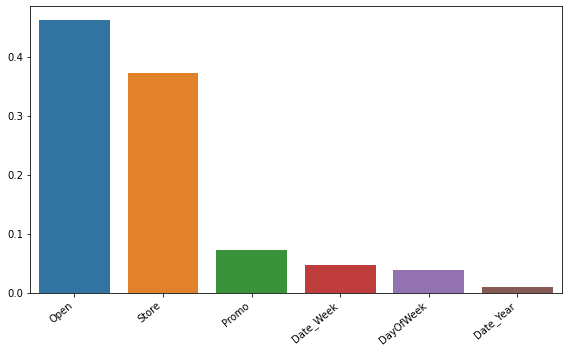

In [14]:
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(8,5)) 
ax=sns.barplot(x=feature_names[indices], y=importances[indices])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")  #it will rotate text on x axis

plt.tight_layout()
plt.show()

In [15]:
df = X_test[["Store", "Date"]]
df["Predicted_Sales"] = pipe_RF.predict(X_test)
df["Real_Sales"] = Y_test

<ipython-input-15-6fb81ebee881>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Predicted_Sales"] = pipe_RF.predict(X_test)
<ipython-input-15-6fb81ebee881>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Real_Sales"] = Y_test


In [16]:
df["err_rel"] = np.abs((df["Predicted_Sales"] - df["Real_Sales"])) / df["Real_Sales"]
df

<ipython-input-16-2de63a6c4aef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["err_rel"] = np.abs((df["Predicted_Sales"] - df["Real_Sales"])) / df["Real_Sales"]


,Store,Date,Predicted_Sales,Real_Sales,err_rel
0,1,2015-07-31,5560.22,5263,0.056473
1,2,2015-07-31,5726.54,6064,0.055650
2,3,2015-07-31,7395.72,8314,0.110450
3,4,2015-07-31,9513.74,13995,0.320204
4,5,2015-07-31,6194.02,4822,0.284533
...,...,...,...,...,...
47940,1111,2015-06-19,6384.75,5618,0.136481
47941,1112,2015-06-19,10699.66,11240,0.048073
47942,1113,2015-06-19,7487.63,7114,0.052520
47943,1114,2015-06-19,23472.30,21834,0.075034


In [17]:
df_err_store = store[["Store", "StoreType"]]

df_err_store["rmse"] = df_err_store.apply(
    lambda row : mean_squared_error(
        df.loc[df["Store"] == row["Store"],"Real_Sales"],
        df.loc[df["Store"] == row["Store"],"Predicted_Sales"],
        squared = False),
    axis = 1
)
df_err_store["mean_sales"] = df_err_store.apply(
    lambda row : df.loc[df["Store"] == row["Store"],"Real_Sales"].mean(),
    axis = 1
)
df_err_store.head()

<ipython-input-17-108cab38c87b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_store["rmse"] = df_err_store.apply(
<ipython-input-17-108cab38c87b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err_store["mean_sales"] = df_err_store.apply(


,Store,StoreType,rmse,mean_sales
0,1,c,616.740451,3774.883721
1,2,a,697.367023,4254.325581
2,3,a,980.341580,5911.395349
3,4,c,1341.141508,8590.186047
4,5,a,693.855580,3881.511628


In [18]:
df_err_date = pd.DataFrame(
    data = {"Date" : df["Date"].unique()}
)

df_err_date["rmse"] = df_err_date.apply(
    lambda row : mean_squared_error(
        df.loc[df["Date"] == row["Date"],"Real_Sales"],
        df.loc[df["Date"] == row["Date"],"Predicted_Sales"],
        squared = False),
    axis = 1
)

df_err_date["mean_sales"] = df_err_date.apply(
    lambda row : df.loc[df["Date"] == row["Date"],"Real_Sales"].mean(),
    axis = 1
)
df_err_date.head()

,Date,rmse,mean_sales
0,2015-07-31,2333.020739,9067.033184
1,2015-07-30,1597.943888,7891.348879
2,2015-07-29,1360.378092,7623.284305
3,2015-07-28,1070.306626,8174.953363
4,2015-07-27,1971.026537,9602.952466


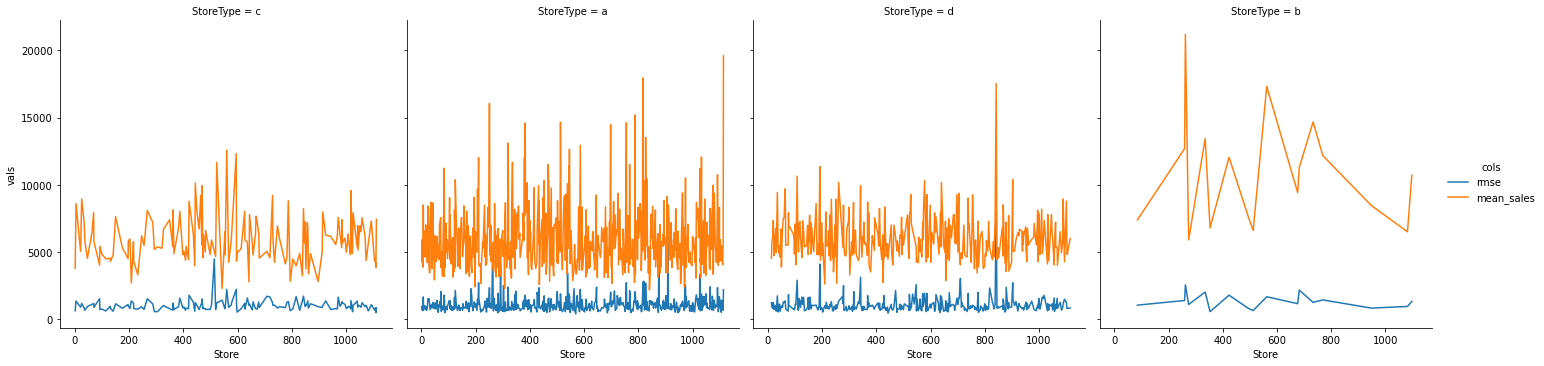

In [19]:
t = df_err_store.melt(['Store', "StoreType"], var_name='cols',  value_name='vals')     

sns.relplot(
    x="Store",
    y="vals",
    hue='cols',
    col='StoreType',
    kind="line",
    data=t)

<AxesSubplot:xlabel='Date', ylabel='vals'>

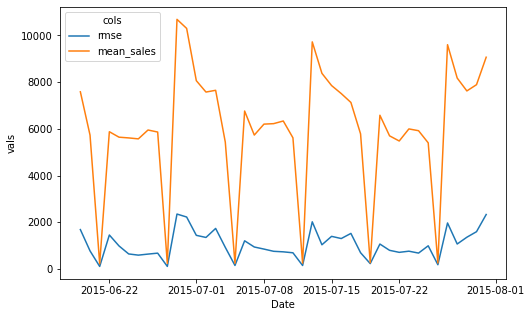

In [20]:
t = df_err_date.melt('Date', var_name='cols',  value_name='vals')     

plt.figure(figsize=(8,5)) 
sns.lineplot(
    x="Date",
    y="vals",
    hue='cols',
    data=t)

In [21]:
df_err_date
df_err_date.melt('Date', var_name='cols',  value_name='vals')   

,Date,cols,vals
0,2015-07-31,rmse,2333.020739
1,2015-07-30,rmse,1597.943888
2,2015-07-29,rmse,1360.378092
3,2015-07-28,rmse,1070.306626
4,2015-07-27,rmse,1971.026537
...,...,...,...
81,2015-06-23,mean_sales,5643.382960
82,2015-06-22,mean_sales,5876.715695
83,2015-06-21,mean_sales,224.079821
84,2015-06-20,mean_sales,5731.534529
